### Chest Xray ConvNet

In [ ]:
# importing the libraries
%%capture
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# mounting the google drive to access the chest dataset
from google.colab import drive
drive.mount('/content/gdrive')
!ls 'gdrive/My Drive/Chest/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
test  train  val


In [ ]:
# setting data path data seperated by class name
training_dir = 'gdrive/My Drive/Chest/train'
testing_dir = 'gdrive/My Drive/Chest/test'
validation_dir = 'gdrive/My Drive/Chest/val'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
#data augmentation
rescale = 1./255
train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
print("Training...")
train_generator = train_datagen.flow_from_directory(
   training_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')
print("Validation...")
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
   validation_dir,
    target_size=(150, 150),
    batch_size=32)

Training...
Found 5216 images belonging to 2 classes.
Validation...
Found 320 images belonging to 2 classes.


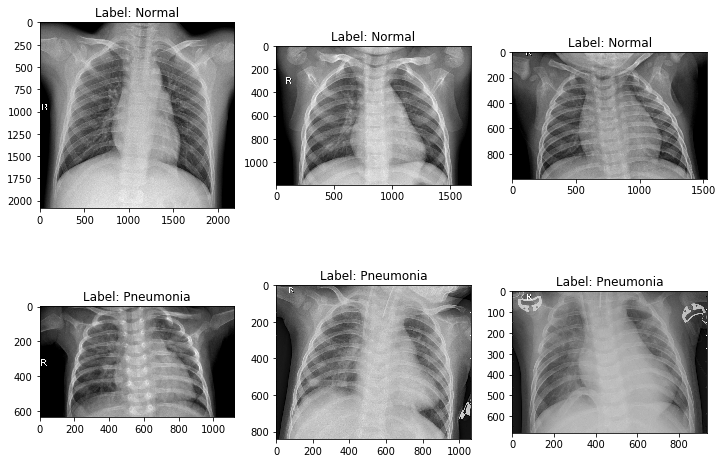

In [50]:
#visualization
input_path = '/content/gdrive/My Drive/Chest/'

fig, ax = plt.subplots(2, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Label: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Label: Pneumonia'.format(_set))

In [ ]:
# importing keras sequential
from keras.models import Sequential
from keras.layers import Dense , Activation, BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import SGD,Adam 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(150,150,3)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='softmax'))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 37, 64)       

In [ ]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [23]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [ ]:
# model.load_weights('/content/conv_weights.h5')
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping, TensorBoard
filepath="/content/gdrive/My Drive/Models/con.hdf5"
logs = "/content/gdrive/My Drive/Logs/"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, verbose=1)
reduce_on_plateau = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.1, patience=4, verbose=1)
early_stopping = EarlyStopping( monitor='val_loss',patience=10,verbose=1,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=logs, histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True, update_freq='epoch')
callbacks_list = [checkpoint, reduce_on_plateau, early_stopping, tensorboard]

In [26]:
history = model.fit_generator(train_generator, epochs=50,
                              callbacks=callbacks_list, verbose = 1,
                              validation_data = validation_generator,
                              workers=-1,class_weight=class_weight)

Epoch 1/50
163/163 [==============================] - 3293s 20s/step - loss: 0.5717 - acc: 0.7431 - val_loss: 0.5639 - val_acc: 0.8063

Epoch 00001: val_loss improved from inf to 0.56391, saving model to /content/gdrive/My Drive/Models/con.hdf5
Epoch 2/50
163/163 [==============================] - 89s 546ms/step - loss: 0.3294 - acc: 0.8553 - val_loss: 0.3188 - val_acc: 0.8625

Epoch 00002: val_loss improved from 0.56391 to 0.31882, saving model to /content/gdrive/My Drive/Models/con.hdf5
Epoch 3/50
163/163 [==============================] - 89s 547ms/step - loss: 0.2454 - acc: 0.9003 - val_loss: 0.2693 - val_acc: 0.8844

Epoch 00003: val_loss improved from 0.31882 to 0.26926, saving model to /content/gdrive/My Drive/Models/con.hdf5
Epoch 4/50
163/163 [==============================] - 90s 550ms/step - loss: 0.1969 - acc: 0.9227 - val_loss: 0.3444 - val_acc: 0.8531

Epoch 00004: val_loss did not improve from 0.26926
Epoch 5/50
163/163 [==============================] - 89s 547ms/step -

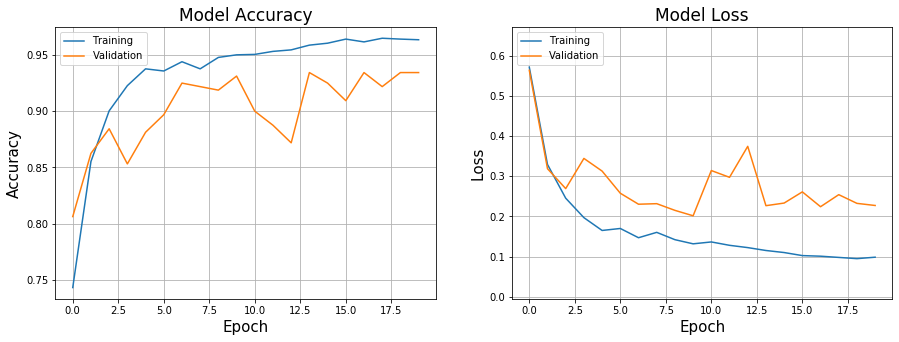

In [36]:
# plotting the accuracy vs loss with the number of Epochs
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]

plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [ ]:
# load weights
model.load_weights('/content/gdrive/My Drive/Models/con.hdf5')

In [28]:
# image generator test directory
rescale = 1./255
test_gen = ImageDataGenerator(rescale=rescale)
test_generator = test_gen.flow_from_directory(
    testing_dir,
    target_size=(150,150),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')
print(test_generator.class_indices)

Found 320 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [29]:
# Evaluation
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1,workers=-1)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
320/320 [==============================] - 202s 633ms/step
Loss     : 0.36  
Accuracy : 90.62%


In [30]:
# Predicting the test set
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1, workers=-1)
print(predictions.shape)
y_pred = np.argmax(predictions, axis=1)
y_test = test_generator.classes

320/320 [==============================] - 4s 12ms/step
(320, 2)


In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
print("Classification Report")
report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print(report)

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.94      0.80      0.87       121
   PNEUMONIA       0.89      0.97      0.93       199

    accuracy                           0.91       320
   macro avg       0.92      0.89      0.90       320
weighted avg       0.91      0.91      0.90       320



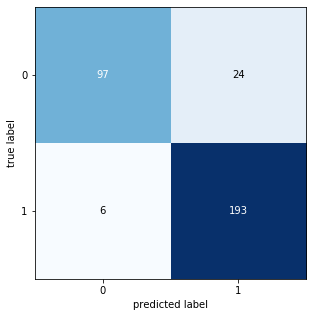

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [45]:
from sklearn.metrics import accuracy_score
tn, fp, fn, tp = CM.ravel()
print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)
recall = tp/(tp+fn)
# print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))


TEST METRICS ----------------------
Precision: 0.8894009216589862%
Recall: 0.9698492462311558%
F1-score: 0.9278846153846153

TRAIN METRIC ----------------------
Train acc: 96.36
